# **Cálculo del número básico de reproducción ($R_0$) en modelos epidemiológicos mediante el método de próxima generación.**

# 📦 GeneralEpidemiologicalModel

Modelo general en Python para calcular el número básico de reproducción $R_0$ mediante el método de próxima generación, aplicado a sistemas arbitrarios de ecuaciones diferenciales en epidemiología.

---

## ✅ Funcionalidades principales

- Cálculo **automático o manual** de términos de nueva infección $\mathcal{F}$.
- Detección del **equilibrio libre de enfermedad** (DFE).
- Construcción simbólica de matrices $\mathbf{F}$ y $\mathbf{V}$.
- Evaluación en el equilibrio y cálculo simbólico del valor de $R_0$.
- Aplicable a modelos como SIR, SEIR, vectoriales, multiespecie, etc.

---


In [10]:
import sympy as sp
from sympy import symbols, Matrix, diff, simplify, pprint, solve, Eq

class GeneralEpidemiologicalModel:
    def __init__(self, variables, parameters, equations, infected_indices, 
                 new_infection_terms=None, equilibrium_point=None, total_population=None):
        """
        variables: lista de símbolos (e.g. [S, I])
        parameters: lista de símbolos (e.g. [beta, gamma, d, b])
        equations: lista de ecuaciones diferenciales (ordenadas según variables)
        infected_indices: índices de variables infectadas (e.g. [1] si I está en la posición 1)
        new_infection_terms: términos de nueva infección (opcional, se calculan automáticamente si no se especifican)
        equilibrium_point: punto de equilibrio libre de enfermedad (opcional, se calcula automáticamente)
        total_population: símbolo que representa la población total (para modelos con N constante)
        """
        self.variables = Matrix(variables)
        self.parameters = parameters
        self.system_equations = Matrix(equations)
        self.infected_indices = infected_indices
        self.total_population = total_population
        
        # Calcular automáticamente o usar los valores proporcionados
        if new_infection_terms is not None:
            self.new_infection_terms = Matrix(new_infection_terms)
            print("Usando términos de nueva infección especificados manualmente.")
        else:
            self.new_infection_terms = self._identify_new_infection_terms()
        
        if equilibrium_point is not None:
            self.equilibrium_point = Matrix(equilibrium_point)
            print("Usando equilibrio libre de enfermedad especificado manualmente.")
        else:
            self.equilibrium_point = self._calculate_disease_free_equilibrium()
    
    def _identify_new_infection_terms(self):
        """
        Identifica automáticamente los términos de nueva infección.
        Los términos de nueva infección son aquellos que:
        1. Aparecen como términos positivos en ecuaciones de compartimentos infectados
        2. Involucran interacciones entre compartimentos (productos de variables)
        3. Representan el flujo DE compartimentos no infectados HACIA compartimentos infectados
        """
        print("Identificando automáticamente términos de nueva infección...")
        
        new_infection_terms = []
        
        for i, equation in enumerate(self.system_equations):
            infection_terms_for_var = []
            
            # Expandir la ecuación y separar términos
            expanded = sp.expand(equation)
            if expanded.is_Add:
                terms = expanded.args
            else:
                terms = [expanded]
            
            for term in terms:
                # Identificar términos de infección basados en varios criterios
                if self._is_infection_term(term, i):
                    infection_terms_for_var.append(term)
            
            # Sumar todos los términos de infección identificados
            if infection_terms_for_var:
                new_infection_terms.append(sum(infection_terms_for_var))
            else:
                new_infection_terms.append(0)
        
        print("Términos de nueva infección identificados:")
        for i, term in enumerate(new_infection_terms):
            print(f"  {self.variables[i]}: {term}")
        
        return Matrix(new_infection_terms)
    
    def _is_infection_term(self, term, var_index):
        """
        Determina si un término representa una nueva infección.
        
        Criterios para términos de nueva infección:
        1. El término debe aparecer en la ecuación de un compartimento infectado
        2. Debe ser un término positivo (no tener signo negativo)
        3. Debe involucrar interacciones entre variables (productos)
        4. Debe representar transmisión desde compartimentos susceptibles
        """
        # Solo considerar términos en ecuaciones de compartimentos infectados
        if var_index not in self.infected_indices:
            return False
        
        # Verificar si es un término positivo
        if term.has(-1):
            return False
        
        # Obtener variables en el término
        term_vars = term.free_symbols.intersection(set(self.variables))
        
        # Debe involucrar al menos 2 variables (interacción)
        if len(term_vars) < 2:
            return False
        
        # Verificar patrones específicos de transmisión
        # 1. Productos que involucran al menos una variable de cada tipo
        has_infected_var = any(i in self.infected_indices for i, var in enumerate(self.variables) if var in term_vars)
        has_susceptible_var = any(i not in self.infected_indices for i, var in enumerate(self.variables) if var in term_vars)
        
        # Para ser término de infección, debe haber interacción entre susceptibles e infectados
        if has_infected_var and has_susceptible_var:
            return True
        
        # Caso especial: términos que solo involucran variables infectadas
        # pero representan nuevas infecciones (como en modelos más complejos)
        if has_infected_var and not has_susceptible_var:
            # Estos podrían ser términos de reinfección o transmisión indirecta
            # Los incluimos si aparecen como términos positivos
            return True
        
        return False
    
    def _calculate_disease_free_equilibrium(self):
        """
        Calcula automáticamente el equilibrio libre de enfermedad.
        En este equilibrio, todas las variables infectadas son cero.
        """
        print("\nCalculando equilibrio libre de enfermedad...")
        
        # Establecer variables infectadas en cero
        infected_zero_conditions = {}
        for i in self.infected_indices:
            infected_zero_conditions[self.variables[i]] = 0
        
        # Para las variables no infectadas, resolver el sistema en equilibrio
        non_infected_indices = [i for i in range(len(self.variables)) if i not in self.infected_indices]
        non_infected_vars = [self.variables[i] for i in non_infected_indices]
        
        equilibrium_point = [0] * len(self.variables)
        
        # Establecer variables infectadas en cero
        for i in self.infected_indices:
            equilibrium_point[i] = 0
        
        if non_infected_vars:
            # Sustituir variables infectadas por cero en las ecuaciones
            equilibrium_eqs = [eq.subs(infected_zero_conditions) for eq in self.system_equations]
            
            # Resolver solo las ecuaciones de variables no infectadas
            non_infected_eqs = [equilibrium_eqs[i] for i in non_infected_indices]
            
            try:
                solutions = solve(non_infected_eqs, non_infected_vars, dict=True)
                if solutions and len(solutions) > 0:
                    solution = solutions[0]  # Tomar la primera solución
                    # Aplicar soluciones encontradas
                    for i in non_infected_indices:
                        var = self.variables[i]
                        if var in solution:
                            equilibrium_point[i] = solution[var]
                        else:
                            equilibrium_point[i] = sp.Symbol(f'{var}_eq', positive=True)
                else:
                    # Si no hay solución, usar símbolos genéricos
                    for i in non_infected_indices:
                        var = self.variables[i]
                        equilibrium_point[i] = sp.Symbol(f'{var}_eq', positive=True)
            except Exception as e:
                print(f"Error al resolver equilibrium: {e}")
                print("Usando valores simbólicos para variables no infectadas.")
                for i in non_infected_indices:
                    var = self.variables[i]
                    equilibrium_point[i] = sp.Symbol(f'{var}_eq', positive=True)
        
        print("Equilibrio libre de enfermedad:")
        for i, val in enumerate(equilibrium_point):
            print(f"  {self.variables[i]} = {val}")
        
        return Matrix(equilibrium_point)
    
    def identify_F_V_terms(self):
        """
        Identifica los términos F (nuevas infecciones) y V (otras transiciones) del sistema.
        """
        print(f"\n{'='*50}")
        print("ANÁLISIS DEL SISTEMA")
        print(f"{'='*50}")
        print("Sistema de ecuaciones:")
        pprint(self.system_equations)
        
        # Términos de nuevas infecciones (identificados automáticamente)
        F = self.new_infection_terms
        
        # Términos restantes (todo lo demás)
        V = F - self.system_equations
        
        print("\nTérminos F (nuevas infecciones):")
        pprint(F)
        print("\nTérminos V (otras transiciones):")
        pprint(V)
        
        return F, V

    def calculate_next_generation_matrices(self):
        """
        Calcula las matrices F y V del método de próxima generación.
        """
        F, V = self.identify_F_V_terms()
        n = len(self.variables)
        
        # Calcular matrices jacobianas
        F_matrix = Matrix([[diff(F[i], self.variables[j]) for j in range(n)] for i in range(n)])
        V_matrix = Matrix([[diff(V[i], self.variables[j]) for j in range(n)] for i in range(n)])
        
        print("\nMatriz Jacobiana F (antes de evaluar en equilibrio):")
        pprint(F_matrix)
        print("\nMatriz Jacobiana V (antes de evaluar en equilibrio):")
        pprint(V_matrix)    
        
        # Evaluar en equilibrio libre de enfermedad
        subs_dict = dict(zip(self.variables, self.equilibrium_point))
        F_eq = F_matrix.subs(subs_dict)
        V_eq = V_matrix.subs(subs_dict)
        
        print("\nMatriz F evaluada en equilibrio:")
        pprint(F_eq)
        print("\nMatriz V evaluada en equilibrio:")
        pprint(V_eq)        
        
        return F_eq, V_eq
    
    def calculate_R0(self):
        """
        Calcula R0 usando el método de la matriz de próxima generación.
        """
        F_eq, V_eq = self.calculate_next_generation_matrices()
        
        # Extraer submatrices correspondientes a compartimentos infectados
        F_sub = F_eq.extract(self.infected_indices, self.infected_indices)
        V_sub = V_eq.extract(self.infected_indices, self.infected_indices)
        
        print("\nSubmatriz F (compartimentos infectados):")
        pprint(F_sub)
        print("\nSubmatriz V (compartimentos infectados):")
        pprint(V_sub)

        try:
            # Calcular V^(-1)
            V_inv = V_sub.inv()
            print("\nInversa de V:")
            pprint(V_inv)
            
            # Calcular FV^(-1)
            FV_inv = F_sub * V_inv
            print("\nMatriz de próxima generación (FV^(-1)):")
            pprint(FV_inv)
            
            # El número de reproducción básico es el radio espectral (mayor valor propio)
            eigenvals = FV_inv.eigenvals()
            print("\nValores propios:")
            for eigenval, mult in eigenvals.items():
                print(f"λ = {eigenval}, multiplicidad = {mult}")
            
            # Tomar el mayor valor propio real
            R0 = simplify(max(eigenvals.keys(), key=lambda x: x.evalf() if x.is_real else -float('inf')))
            return R0
            
        except Exception as e:
            print(f"Error al calcular R0: {e}")
            print("Verificar que la matriz V sea invertible y que los compartimentos infectados estén bien definidos.")
            return None

# Ejemplo 1: 

In [87]:
print("="*60)
print("MODELO S-I (con natalidad y mortalidad)")
print("="*60)

# Variables
I, S = sp.symbols('I S')

# Parámetros
beta, gamma, d, b = sp.symbols('beta gamma d b', positive=True)

variables = [I, S]
parameters = [beta, gamma, d, b]

# Sistema de ecuaciones
dI = beta*S*I - (gamma + d)*I
dS = b - beta*S*I + gamma*I - d*S

equations = [dI, dS]  # Orden: [I, S]

# Índice de compartimentos infectados (solo I)
infected_indices = [0]

# Crear y analizar el modelo
model = GeneralEpidemiologicalModel(
    variables,
    parameters,
    equations,
    infected_indices
)

R0 = model.calculate_R0()

print(f"\n{'='*60}")
print("RESULTADO FINAL")
print(f"{'='*60}")
print("R0 del sistema (modelo S-I):")
if R0 is not None:
    pprint(R0)
    print(f"\nR0 simplificado: {simplify(R0)}")
else:
    print("No se pudo calcular R0")


MODELO S-I (con natalidad y mortalidad)
Identificando automáticamente términos de nueva infección...
Términos de nueva infección identificados:
  I: I*S*beta
  S: 0

Calculando equilibrio libre de enfermedad...
Equilibrio libre de enfermedad:
  I = 0
  S = b/d

ANÁLISIS DEL SISTEMA
Sistema de ecuaciones:
⎡  I⋅S⋅β - I⋅(d + γ)   ⎤
⎢                      ⎥
⎣-I⋅S⋅β + I⋅γ - S⋅d + b⎦

Términos F (nuevas infecciones):
⎡I⋅S⋅β⎤
⎢     ⎥
⎣  0  ⎦

Términos V (otras transiciones):
⎡      I⋅(d + γ)      ⎤
⎢                     ⎥
⎣I⋅S⋅β - I⋅γ + S⋅d - b⎦

Matriz Jacobiana F (antes de evaluar en equilibrio):
⎡S⋅β  I⋅β⎤
⎢        ⎥
⎣ 0    0 ⎦

Matriz Jacobiana V (antes de evaluar en equilibrio):
⎡ d + γ      0   ⎤
⎢                ⎥
⎣S⋅β - γ  I⋅β + d⎦

Matriz F evaluada en equilibrio:
⎡b⋅β   ⎤
⎢───  0⎥
⎢ d    ⎥
⎢      ⎥
⎣ 0   0⎦

Matriz V evaluada en equilibrio:
⎡ d + γ   0⎤
⎢          ⎥
⎢b⋅β       ⎥
⎢─── - γ  d⎥
⎣ d        ⎦

Submatriz F (compartimentos infectados):
⎡b⋅β⎤
⎢───⎥
⎣ d ⎦

Submatriz V (compa

# Ejemplo 2: Modelo I-V-E-T
$$
dI = k*E*V - a*I - \beta*T*I$$
$$dV = v*I - u*V - t*T*V  $$
$$dE = l - d*E - k*E*V$$
$$dT = b - c*T + g*I*T
$$


In [76]:
# Ejemplo: Modelo I-V-E-T
print("="*60)
print("MODELO I-V-E-T")
print("="*60)

# Variables del sistema
I, V, E, T = sp.symbols('I V E T')

# Parámetros
k, a, beta, v, u, t, l, d, b, c, g = sp.symbols('k a beta v u t l d b c g', positive=True)

variables = [I, V, E, T]
parameters = [k, a, beta, v, u, t, l, d, b, c, g]

# Sistema de ecuaciones diferenciales
dI = k*E*V - a*I - beta*T*I  # Infección viral
dV = v*I - u*V - t*T*V       # Dinámica viral
dE = l - d*E - k*E*V         # Células epiteliales
dT = b - c*T + g*I*T         # Respuesta inmune

equations = [dI, dV, dE, dT]  # Orden: [I, V, E, T]

# Índices de compartimentos infectados (I y V)
infected_indices = [0, 1]

# Crear y analizar el modelo (ahora completamente automatizado)
model = GeneralEpidemiologicalModel(
    variables, 
    parameters, 
    equations, 
    infected_indices
)

R0 = model.calculate_R0()

print(f"\n{'='*60}")
print("RESULTADO FINAL")
print(f"{'='*60}")
print("R0 del sistema (modelo I-V-E-T):")
if R0 is not None:
    pprint(R0)
    print(f"\nR0 simplificado: {simplify(R0)}")
else:
    print("No se pudo calcular R0")


MODELO I-V-E-T
Identificando automáticamente términos de nueva infección...
Términos de nueva infección identificados:
  I: E*V*k
  V: 0
  E: 0
  T: 0

Calculando equilibrio libre de enfermedad...
Equilibrio libre de enfermedad:
  I = 0
  V = 0
  E = l/d
  T = b/c

ANÁLISIS DEL SISTEMA
Sistema de ecuaciones:
⎡E⋅V⋅k - I⋅T⋅β - I⋅a⎤
⎢                   ⎥
⎢ I⋅v - T⋅V⋅t - V⋅u ⎥
⎢                   ⎥
⎢ -E⋅V⋅k - E⋅d + l  ⎥
⎢                   ⎥
⎣  I⋅T⋅g - T⋅c + b  ⎦

Términos F (nuevas infecciones):
⎡E⋅V⋅k⎤
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎣  0  ⎦

Términos V (otras transiciones):
⎡   I⋅T⋅β + I⋅a    ⎤
⎢                  ⎥
⎢-I⋅v + T⋅V⋅t + V⋅u⎥
⎢                  ⎥
⎢ E⋅V⋅k + E⋅d - l  ⎥
⎢                  ⎥
⎣ -I⋅T⋅g + T⋅c - b ⎦

Matriz Jacobiana F (antes de evaluar en equilibrio):
⎡0  E⋅k  V⋅k  0⎤
⎢              ⎥
⎢0   0    0   0⎥
⎢              ⎥
⎢0   0    0   0⎥
⎢              ⎥
⎣0   0    0   0⎦

Matriz Jacobiana V (antes de evaluar en equilibrio):
⎡T⋅β + a     0        0       I⋅β   ⎤


# Simulación


SIMULACIÓN MODELO I-V-E-T


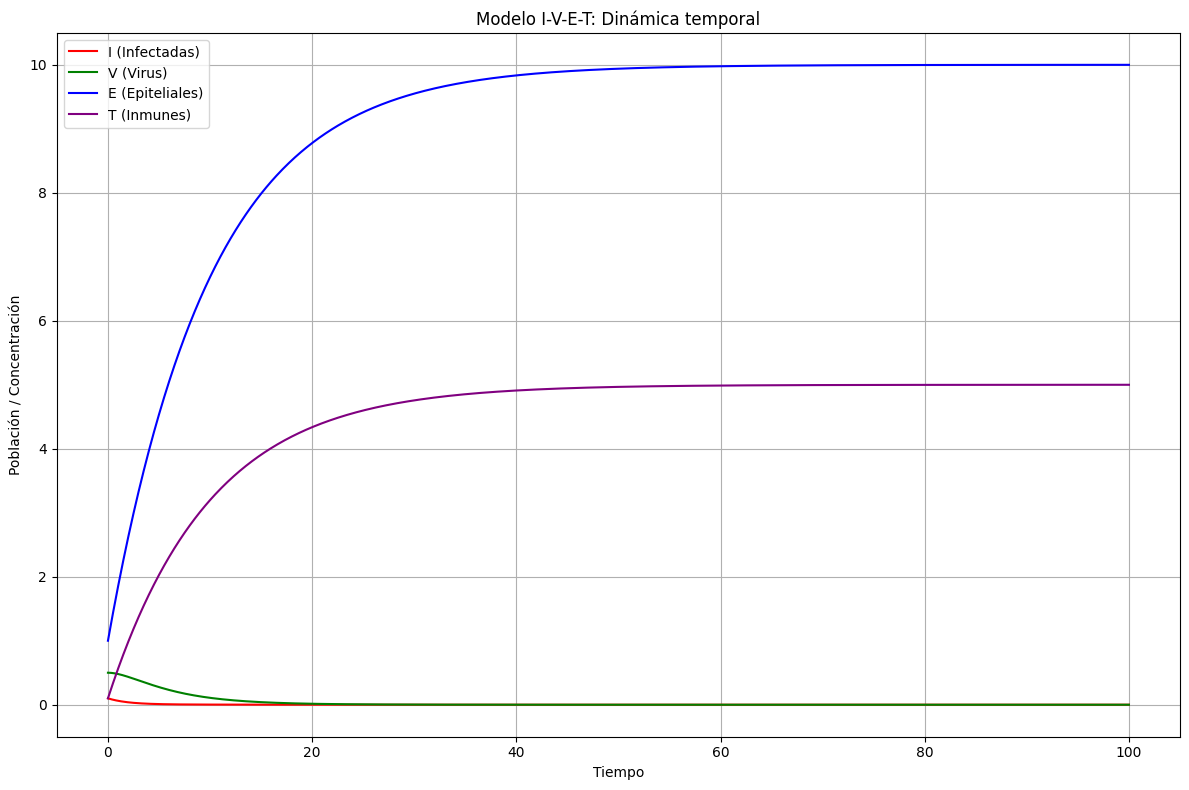

Condiciones iniciales: I0=0.1, V0=0.5, E0=1.0, T0=0.1


In [74]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def simulate_ivet_model():
    """Simula numéricamente el modelo I-V-E-T"""

    print("\n" + "="*60)
    print("SIMULACIÓN MODELO I-V-E-T")
    print("="*60)

    # Parámetros
    params = {
        'k': 0.001,    # infección (interacción E-V)
        'a': 0.5,      # muerte de I
        'beta': 0.01,  # eliminación de I por T
        'v': 1.0,      # producción de V por I
        'u': 0.2,      # degradación natural de V
        't': 0.005,    # eliminación de V por T
        'l': 1.0,      # tasa de regeneración de E
        'd': 0.1,      # muerte natural de E
        'b': 0.5,      # producción de T
        'c': 0.1,      # muerte natural de T
        'g': 0.005     # estimulación de T por I
    }

    # Sistema de ecuaciones diferenciales
    def ivet_system(y, t, p):
        I, V, E, T = y
        dI_dt = p['k']*E*V - p['a']*I - p['beta']*T*I
        dV_dt = p['v']*I - p['u']*V - p['t']*T*V
        dE_dt = p['l'] - p['d']*E - p['k']*E*V
        dT_dt = p['b'] - p['c']*T + p['g']*I*T
        return [dI_dt, dV_dt, dE_dt, dT_dt]

    # Condiciones iniciales
    y0 = [0.1, 0.5, 1.0, 0.1]  # I0, V0, E0, T0

    # Tiempo de simulación
    t = np.linspace(0, 100, 1000)

    # Resolver el sistema
    sol = odeint(ivet_system, y0, t, args=(params,))

    # Graficar los resultados
    labels = ['I (Infectadas)', 'V (Virus)', 'E (Epiteliales)', 'T (Inmunes)']
    colors = ['r', 'g', 'b', 'purple']

    plt.figure(figsize=(12, 8))
    for i in range(4):
        plt.plot(t, sol[:, i], label=labels[i], color=colors[i])
    plt.xlabel('Tiempo')
    plt.ylabel('Población / Concentración')
    plt.title('Modelo I-V-E-T: Dinámica temporal')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Condiciones iniciales: I0={y0[0]}, V0={y0[1]}, E0={y0[2]}, T0={y0[3]}")

simulate_ivet_model()


In [84]:
from sympy import symbols, simplify

# Definición simbólica de parámetros
k, a, beta, v, u, t, l, d, b, c = symbols('k a beta v u t l d b c', positive=True)

# Expresión simbólica de R0 (ya simplificada)
R0_symbolic = (c**2 * k * l * v) / (d * (a * c + b * beta) * (b * t + c * u))

# Diccionario de valores numéricos
param_values = {
    k: 0.1,
    a: 0.5,
    beta: 0.1,
    v: 1.0,
    u: 0.2,
    t: 0.005,
    l: 1.0,
    d: 0.1,
    b: 0.5,
    c: 0.1
}

# Sustitución numérica
R0_eval = R0_symbolic.subs(param_values).evalf()

# Mostrar resultados
print("\n" + "="*60)
print("VALOR NUMÉRICO DE R0")
print("="*60)
print(f"R0 simbólico = {simplify(R0_symbolic)}")
print(f"R0 evaluado numéricamente: {R0_eval:.6f}")

# Interpretación
print("\nINTERPRETACIÓN BIOLÓGICA:")
if R0_eval > 1:
    print(f"→ R0 = {R0_eval:.3f} > 1 → La infección puede propagarse en la población.")
elif R0_eval < 1:
    print(f"→ R0 = {R0_eval:.3f} < 1 → La infección tiende a desaparecer con el tiempo.")
else:
    print(f"→ R0 = {R0_eval:.3f} = 1 → La infección se mantiene en equilibrio crítico.")



VALOR NUMÉRICO DE R0
R0 simbólico = c**2*k*l*v/(d*(a*c + b*beta)*(b*t + c*u))
R0 evaluado numéricamente: 4.444444

INTERPRETACIÓN BIOLÓGICA:
→ R0 = 4.444 > 1 → La infección puede propagarse en la población.


# Ejemplo 3: Cuando la identificación automática falla
\begin{align*}
\frac{dS}{dt} &= -\beta_{\text{sir}} \frac{S I}{N} \\
\frac{dI}{dt} &= \beta_{\text{sir}} \frac{S I}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{align*}

In [5]:
# Ejemplo con detección automática mejorada
print("\n" + "="*60)
print("MODELO SIR CLÁSICO (DETECCIÓN AUTOMÁTICA)")
print("="*60)
# Variables del modelo SIR
S, I, R = sp.symbols('S I R')
beta, gamma, N = sp.symbols('beta gamma N', positive=True)

variables_sir = [I, S, R]
parameters_sir = [beta, gamma, N]

# Sistema SIR
dS = -beta*S*I/N
dI = beta*S*I/N - gamma*I
dR = gamma*I

equations_sir = [dI, dS, dR]
infected_indices_sir = [0]  # Solo I es infectado

# Intentar con detección automática
model_sir_auto = GeneralEpidemiologicalModel(
    variables_sir,
    parameters_sir,
    equations_sir,
    infected_indices_sir
)

R0_sir_auto = model_sir_auto.calculate_R0()

print(f"\n{'='*40}")
print("RESULTADO MODELO SIR (AUTOMÁTICO)")
print(f"{'='*40}")
if R0_sir_auto is not None:
    print("R0 del modelo SIR (automático):")
    pprint(R0_sir_auto)
    print(f"\nR0 simplificado: {simplify(R0_sir_auto)}")


MODELO SIR CLÁSICO (DETECCIÓN AUTOMÁTICA)
Identificando automáticamente términos de nueva infección...
Términos de nueva infección identificados:
  I: 0
  S: 0
  R: 0

Calculando equilibrio libre de enfermedad...
Equilibrio libre de enfermedad:
  I = 0
  S = S_eq
  R = R_eq

ANÁLISIS DEL SISTEMA
Sistema de ecuaciones:
⎡       I⋅S⋅β⎤
⎢-I⋅γ + ─────⎥
⎢         N  ⎥
⎢            ⎥
⎢  -I⋅S⋅β    ⎥
⎢  ───────   ⎥
⎢     N      ⎥
⎢            ⎥
⎣    I⋅γ     ⎦

Términos F (nuevas infecciones):
⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

Términos V (otras transiciones):
⎡      I⋅S⋅β⎤
⎢I⋅γ - ─────⎥
⎢        N  ⎥
⎢           ⎥
⎢   I⋅S⋅β   ⎥
⎢   ─────   ⎥
⎢     N     ⎥
⎢           ⎥
⎣   -I⋅γ    ⎦

Matriz Jacobiana F (antes de evaluar en equilibrio):
⎡0  0  0⎤
⎢       ⎥
⎢0  0  0⎥
⎢       ⎥
⎣0  0  0⎦

Matriz Jacobiana V (antes de evaluar en equilibrio):
⎡    S⋅β  -I⋅β    ⎤
⎢γ - ───  ─────  0⎥
⎢     N     N     ⎥
⎢                 ⎥
⎢  S⋅β     I⋅β    ⎥
⎢  ───     ───   0⎥
⎢   N       N     ⎥
⎢                 ⎥
⎣  -γ       

# Ejemplo 3: con especificación manual de los términos de nueva infección F

In [86]:
# Ejemplo adicional: Modelo SIR clásico (con especificación manual para mayor precisión)
print("\n" + "="*60)
print("MODELO SIR CLÁSICO (CON ESPECIFICACIÓN MANUAL)")
print("="*60)

# Variables del modelo SIR
S, I, R = sp.symbols('S I R')
beta_sir, gamma, N = sp.symbols('beta gamma N', positive=True)

variables_sir = [I, S, R]
parameters_sir = [beta_sir, gamma, N]

# Sistema SIR
dS = -beta_sir*S*I/N
dI = beta_sir*S*I/N - gamma*I
dR = gamma*I

equations_sir = [dI, dS, dR]
infected_indices_sir = [0]  # Solo I es infectado

# Para el modelo SIR, especificar manualmente los términos de nueva infección
# ya que el término beta*S*I/N representa nueva infección pero aparece tanto en dS como en dI
new_infection_terms_sir = [
    beta_sir*S*I/N,      # I recibe nuevas infecciones de S    
    0,                    # S no recibe nuevas infecciones
    0                     # R no recibe nuevas infecciones
]

# El equilibrio libre de enfermedad para SIR: I=0, y S+R=N (conservación)
# En equilibrio: S=N, I=0, R=0 (sin infección inicial)
equilibrium_sir = [0, N, 0]

# Crear modelo SIR con especificación manual
model_sir = GeneralEpidemiologicalModel(
    variables_sir,
    parameters_sir,
    equations_sir,
    infected_indices_sir,
    new_infection_terms=new_infection_terms_sir,
    equilibrium_point=equilibrium_sir,
    total_population=N
)

R0_sir = model_sir.calculate_R0()

print(f"\n{'='*40}")
print("RESULTADO MODELO SIR")
print(f"{'='*40}")
if R0_sir is not None:
    print("R0 del modelo SIR:")
    pprint(R0_sir)
    print(f"\nR0 simplificado: {simplify(R0_sir)}")


MODELO SIR CLÁSICO (CON ESPECIFICACIÓN MANUAL)
Usando términos de nueva infección especificados manualmente.
Usando equilibrio libre de enfermedad especificado manualmente.

ANÁLISIS DEL SISTEMA
Sistema de ecuaciones:
⎡       I⋅S⋅β⎤
⎢-I⋅γ + ─────⎥
⎢         N  ⎥
⎢            ⎥
⎢  -I⋅S⋅β    ⎥
⎢  ───────   ⎥
⎢     N      ⎥
⎢            ⎥
⎣    I⋅γ     ⎦

Términos F (nuevas infecciones):
⎡I⋅S⋅β⎤
⎢─────⎥
⎢  N  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎣  0  ⎦

Términos V (otras transiciones):
⎡ I⋅γ ⎤
⎢     ⎥
⎢I⋅S⋅β⎥
⎢─────⎥
⎢  N  ⎥
⎢     ⎥
⎣-I⋅γ ⎦

Matriz Jacobiana F (antes de evaluar en equilibrio):
⎡S⋅β  I⋅β   ⎤
⎢───  ───  0⎥
⎢ N    N    ⎥
⎢           ⎥
⎢ 0    0   0⎥
⎢           ⎥
⎣ 0    0   0⎦

Matriz Jacobiana V (antes de evaluar en equilibrio):
⎡ γ    0   0⎤
⎢           ⎥
⎢S⋅β  I⋅β   ⎥
⎢───  ───  0⎥
⎢ N    N    ⎥
⎢           ⎥
⎣-γ    0   0⎦

Matriz F evaluada en equilibrio:
⎡β  0  0⎤
⎢       ⎥
⎢0  0  0⎥
⎢       ⎥
⎣0  0  0⎦

Matriz V evaluada en equilibrio:
⎡γ   0  0⎤
⎢        ⎥
⎢β   0  0⎥
⎢        ⎥


# Ejemplo 4:
\begin{align*}
\frac{dE_h}{dt} &= \delta \alpha_{hv} \frac{S_h I_v}{N_h} + \beta \alpha_{hh} \frac{S_h I_h}{N_h} - (\sigma + \mu_h) E_h \\
\frac{dI_h}{dt} &= \sigma E_h - (\gamma + \mu_h) I_h \\
\frac{dE_v}{dt} &= \delta \alpha_{vh} \frac{S_v I_h}{N_h} - (\psi + \mu_v + \zeta) E_v \\
\frac{dI_v}{dt} &= \psi E_v - (\mu_v + \zeta) I_v \\
\frac{dS_h}{dt} &= \Delta_h - \delta \alpha_{hv} \frac{S_h I_v}{N_h} - \beta \alpha_{hh} \frac{S_h I_h}{N_h} - (\theta + \mu_h) S_h \\
\frac{dR_h}{dt} &= \gamma I_h - \mu_h R_h + \theta S_h \\
\frac{dM_v}{dt} &= \varphi_v M_v \left(1 - \frac{M_v}{\kappa} \right) - (\omega + \mu_m) M_v \\
\frac{dS_v}{dt} &= \omega M_v - \delta \alpha_{vh} \frac{S_v I_h}{N_h} - (\mu_v + \zeta) S_v
\end{align*}

In [6]:
import sympy as sp
from sympy import simplify, pprint, Matrix

# Variables humanas
Eh, Ih, Sh, Rh = sp.symbols('Eh Ih Sh Rh')
# Variables del vector
Ev, Iv, Mv, Sv = sp.symbols('Ev Iv Mv Sv')
# Total poblacional humano
Nh = Sh + Eh + Ih + Rh

# Parámetros
Deltah, delta, alphahv, alphahh, alphavh = sp.symbols('Deltah delta alphahv alphahh alphavh', positive=True)
beta, sigma, gamma, theta = sp.symbols('beta sigma gamma theta', positive=True)
muh, mum, muv, zeta, psi = sp.symbols('muh mum muv zeta psi', positive=True)
kappa, phiv, omega = sp.symbols('kappa phiv omega', positive=True) 
Sh0, Sv0 = sp.symbols('Sh0 Sv0', positive=True) 

# Variables del sistema (orden correcto)
variables = [Eh, Ih, Ev, Iv, Sh, Rh, Mv, Sv]

# Parámetros simbólicos
parameters = [
    Deltah, delta, alphahv, alphahh, alphavh, beta, sigma, gamma, theta,
    muh, mum, muv, zeta, psi, kappa, phiv, omega
]

# Sistema de ecuaciones (en el mismo orden que las variables)
dEh = delta*alphahv*Sh*Iv/Nh + beta*alphahh*Sh*Ih/Nh - (sigma + muh)*Eh
dIh = sigma*Eh - (gamma + muh)*Ih
dEv = delta*alphavh*Sv*Ih/Nh - (psi + muv + zeta)*Ev
dIv = psi*Ev - (muv + zeta)*Iv
dSh = Deltah - delta*alphahv*Sh*Iv/Nh - beta*alphahh*Sh*Ih/Nh - (theta + muh)*Sh
dRh = gamma*Ih - muh*Rh + theta*Sh
dMv = phiv*Mv*(1 - Mv/kappa) - (omega + mum)*Mv
dSv = omega*Mv - delta*alphavh*Sv*Ih/Nh - (muv + zeta)*Sv

equations = [dEh, dIh, dEv, dIv, dSh, dRh, dMv, dSv]

# Compartimentos infectados: E_h, I_h, E_v, I_v (índices 0,1,2,3)
infected_indices = [0, 1, 2, 3]

# Nuevas infecciones para cada compartimento
new_infection_terms = [
    delta*alphahv*Sh*Iv/Nh + beta*alphahh*Sh*Ih/Nh,  # E_h: nuevas infecciones humanas
    0,                                               # I_h: no hay nuevas infecciones directas
    delta*alphavh*Sv*Ih/Nh,                          # E_v: nuevas infecciones vectoriales
    0,                                               # I_v: no hay nuevas infecciones directas
    0,                                               # S_h: no es compartimento infectado
    0,                                               # R_h: no es compartimento infectado
    0,                                               # M_v: no es compartimento infectado
    0                                                # S_v: no es compartimento infectado
]

# Equilibrio libre de enfermedad (DFE) - como lista en orden de variables
DFE_dict = {
    Eh: 0,
    Ih: 0,
    Ev: 0,
    Iv: 0,
    Sh: Sh0, #Deltah / (theta + muh),
    Rh: 0,
    Mv: 0,
    Sv: Sv0 #kappa*(1 - (mum + omega) / phiv)
}

# Convertir DFE a lista en el orden correcto de variables
DFE_list = [DFE_dict[var] for var in variables]



# Crear el modelo
model = GeneralEpidemiologicalModel(
    variables,
    parameters,
    equations,
    infected_indices,
    new_infection_terms=new_infection_terms,
    equilibrium_point=DFE_list
)

# Calcular R0
R0 = model.calculate_R0()

# Mostrar resultados
print(f"\n{'='*60}")
print("RESULTADO FINAL")
print(f"{'='*60}")
print("R0 del sistema (modelo vector-huésped):")
if R0 is not None:
    print("R0 =")
    pprint(R0)
    print(f"\nR0 simplificado:")
    pprint(simplify(R0))
else:
    print("No se pudo calcular R0")

Usando términos de nueva infección especificados manualmente.
Usando equilibrio libre de enfermedad especificado manualmente.

ANÁLISIS DEL SISTEMA
Sistema de ecuaciones:
⎡                     Ih⋅Sh⋅alphahh⋅β     Iv⋅Sh⋅alphahv⋅δ     ⎤
⎢    -Eh⋅(muh + σ) + ───────────────── + ─────────────────    ⎥
⎢                    Eh + Ih + Rh + Sh   Eh + Ih + Rh + Sh    ⎥
⎢                                                             ⎥
⎢                     Eh⋅σ - Ih⋅(γ + muh)                     ⎥
⎢                                                             ⎥
⎢                                 Ih⋅Sv⋅alphavh⋅δ             ⎥
⎢            -Ev⋅(muv + ψ + ζ) + ─────────────────            ⎥
⎢                                Eh + Ih + Rh + Sh            ⎥
⎢                                                             ⎥
⎢                     Ev⋅ψ - Iv⋅(muv + ζ)                     ⎥
⎢                                                             ⎥
⎢          Ih⋅Sh⋅alphahh⋅β     Iv⋅Sh⋅alphahv⋅δ               

In [7]:
import sympy as sp

# Definir variables
alphahh, beta, sigma, gamma, muh, muv, zeta, psi, Sh0, Sv0, alphahv, alphavh, delta = sp.symbols(
    'alphahh beta sigma gamma muh muv zeta psi Sh0 Sv0 alphahv alphavh delta', positive=True)

# Definir R0 original
R0 = (alphahh*beta*sigma)/(2*(gamma + muh)*(muh + sigma)) + \
    sp.sqrt(sigma)*sp.sqrt(muv + zeta)*sp.sqrt(muv + psi + zeta)*sp.sqrt(
        Sh0*alphahh**2*beta**2*muv**2*sigma + Sh0*alphahh**2*beta**2*muv*psi*sigma + 2*Sh0*alphahh**2*beta**2*muv*sigma*zeta + Sh0*alphahh**2*beta**2*psi*sigma*zeta + Sh0*alphahh**2*beta**2*sigma*zeta**2 +
        4*Sv0*alphahv*alphavh*delta**2*gamma*muh*psi + 4*Sv0*alphahv*alphavh*delta**2*gamma*psi*sigma + 4*Sv0*alphahv*alphavh*delta**2*muh**2*psi + 4*Sv0*alphahv*alphavh*delta**2*muh*psi*sigma
    ) / (
        2*sp.sqrt(Sh0)*(gamma*muh*muv**2 + gamma*muh*muv*psi + 2*gamma*muh*muv*zeta + gamma*muh*psi*zeta + gamma*muh*zeta**2 + gamma*muv**2*sigma + gamma*muv*psi*sigma + 2*gamma*muv*sigma*zeta + gamma*psi*sigma*zeta + gamma*sigma*zeta**2 +
        muh**2*muv**2 + muh**2*muv*psi + 2*muh**2*muv*zeta + muh**2*psi*zeta + muh**2*zeta**2 + muh*muv**2*sigma + muh*muv*psi*sigma + 2*muh*muv*sigma*zeta + muh*psi*sigma*zeta + muh*sigma*zeta**2)
    )

# Simplificar
R0_simplified = sp.simplify(R0)

# Mostrar resultado
sp.pprint(R0_simplified, use_unicode=True)


                                                            __________________ ↪
                               _________   _____________   ╱            2  2   ↪
      alphahh⋅β⋅σ         √σ⋅╲╱ muv + ζ ⋅╲╱ muv + ψ + ζ ⋅╲╱  Sh₀⋅alphahh ⋅β ⋅m ↪
─────────────────────── + ──────────────────────────────────────────────────── ↪
(2⋅γ + 2⋅muh)⋅(muh + σ)                          _____ ⎛         2             ↪
                                             2⋅╲╱ Sh₀ ⋅⎝γ⋅muh⋅muv  + γ⋅muh⋅muv ↪

↪ ____________________________________________________________________________ ↪
↪   2                2  2                        2  2                      2   ↪
↪ uv ⋅σ + Sh₀⋅alphahh ⋅β ⋅muv⋅ψ⋅σ + 2⋅Sh₀⋅alphahh ⋅β ⋅muv⋅σ⋅ζ + Sh₀⋅alphahh ⋅β ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                                         2        2                           ↪
↪ ⋅ψ + 2⋅γ⋅muh⋅muv⋅ζ + γ⋅muh⋅ψ⋅ζ + γ⋅muh⋅ζ  + γ⋅muv ⋅σ + γ⋅muv⋅ψ⋅σ + 2⋅γ⋅muv⋅σ ↪

↪ ________________________

In [8]:
import sympy as sp

# Variables y parámetros (simbolos)
beta, alphahh, sigma, gamma, muh = sp.symbols('beta alphahh sigma gamma muh', positive=True)
delta, alphahv, alphavh, psi, muv, zeta = sp.symbols('delta alphahv alphavh psi muv zeta', positive=True)
Sh0, Sv0 = sp.symbols('Sh0 Sv0', positive=True)

# Expresiones intermedias
term1 = beta * alphahh * sigma / (2 * (sigma + muh) * (gamma + muh))

frac1 = beta * alphahh * sigma / ((sigma + muh) * (gamma + muh))
frac2 = (4 * delta**2 * alphahv * alphavh * sigma * psi * Sv0 * Sh0) / \
        ((psi + muv + zeta) * (muv + zeta) * (sigma + muh) * (gamma + muh))

radicand = frac1**2 + frac2

R0 = term1 + 0.5 * sp.sqrt(radicand)

# Mostrar
sp.pprint(R0, use_unicode=True)


                                    __________________________________________ ↪
                                   ╱                                 2         ↪
      alphahh⋅β⋅σ                 ╱       4⋅Sh₀⋅Sv₀⋅alphahv⋅alphavh⋅δ ⋅ψ⋅σ     ↪
─────────────────────── + 0.5⋅   ╱   ───────────────────────────────────────── ↪
(γ + muh)⋅(2⋅muh + 2⋅σ)         ╱    (γ + muh)⋅(muh + σ)⋅(muv + ζ)⋅(muv + ψ +  ↪
                              ╲╱                                               ↪

↪ ___________________________
↪                2  2  2     
↪         alphahh ⋅β ⋅σ      
↪ ── + ───────────────────── 
↪ ζ)            2          2 
↪      (γ + muh) ⋅(muh + σ)  
